# Final Project  
## A Simplified Kinetic-Chain Model of a Boxing Straight Punch (Coupled Mass–Spring System)

**Goal.** Model the “kinetic chain” of a straight punch as a 1D coupled mass–spring system:
ground/legs → trunk → shoulder/upper arm → forearm/fist.

We study:
1) normal modes (coordination patterns),
2) driven motion with staged activation (timing),
3) energy transfer along the chain,
4) numerical method behavior (energy drift / stability),
5) Hamiltonian vs. Lagrangian formulations for the conservative case.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import eigh
import time

def style_ax(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

def max_abs(arr):
    return np.max(np.abs(arr))

def piecewise_half_sine(t, t0, T, F0):
    # half-sine pulse on [t0, t0+T], else 0
    if (t < t0) or (t > t0 + T):
        return 0.0
    tau = (t - t0) / T
    return F0 * np.sin(np.pi * tau)

def solve_ivp_wrapper(fun, t_span, y0, t_eval, method="RK45", rtol=1e-9, atol=1e-9):
    sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, method=method, rtol=rtol, atol=atol)
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol


## Physical model and assumptions

We use a 1D chain model along the punch direction with generalized coordinates
$\mathbf{x} = (x_1,x_2,x_3,x_4)^T$:

wall -- $k_0$ -- $m_1$ -- $k_1$ -- $m_2$ -- $k_2$ -- $m_3$ -- $k_3$ -- $m_4$

- $m_1$: legs/hips (ground drive)
- $m_2$: trunk/torso
- $m_3$: shoulder/upper arm
- $m_4$: forearm/fist (endpoint)

Main (conservative) case: no damping, and we can optionally add a staged external drive
to mimic timing in the kinetic chain.

**Conservative energy (when $F=0$).** In the undriven, undamped case the system is time-translation invariant, so total energy should be conserved (up to numerical error).


In [2]:
def build_M(m1, m2, m3, m4):
    return np.diag([m1, m2, m3, m4])

def build_K(k0, k1, k2, k3):
    # wall--k0--m1--k1--m2--k2--m3--k3--m4
    K = np.zeros((4,4))
    K[0,0] = k0 + k1
    K[0,1] = -k1

    K[1,0] = -k1
    K[1,1] = k1 + k2
    K[1,2] = -k2

    K[2,1] = -k2
    K[2,2] = k2 + k3
    K[2,3] = -k3

    K[3,2] = -k3
    K[3,3] = k3
    return K

def drive_force_vector(t, F0=1.0, Tpush=0.6, delay=0.15, weights=(1.0, 0.7, 0.4, 0.0)):
    """
    3-stage activation:
    - stage 1 on m1 at t0=0
    - stage 2 on m2 at t0=delay
    - stage 3 on m3 at t0=2*delay
    (m4 drive weight default 0)
    """
    w1, w2, w3, w4 = weights
    F1 = piecewise_half_sine(t, 0.0,      Tpush, F0*w1)
    F2 = piecewise_half_sine(t, delay,    Tpush, F0*w2)
    F3 = piecewise_half_sine(t, 2*delay,  Tpush, F0*w3)
    F4 = piecewise_half_sine(t, 3*delay,  Tpush, F0*w4)
    return np.array([F1, F2, F3, F4])

def eom_first_order(t, y, M, K, drive_on=False, F0=1.0, Tpush=0.6, delay=0.15, weights=(1.0,0.7,0.4,0.0)):
    """
    y = [x1..x4, v1..v4]
    M x_ddot + K x = F(t)   (conservative, no damping)
    """
    x = y[:4]
    v = y[4:]
    F = drive_force_vector(t, F0=F0, Tpush=Tpush, delay=delay, weights=weights) if drive_on else np.zeros(4)
    a = np.linalg.solve(M, (F - K @ x))
    return np.concatenate([v, a])


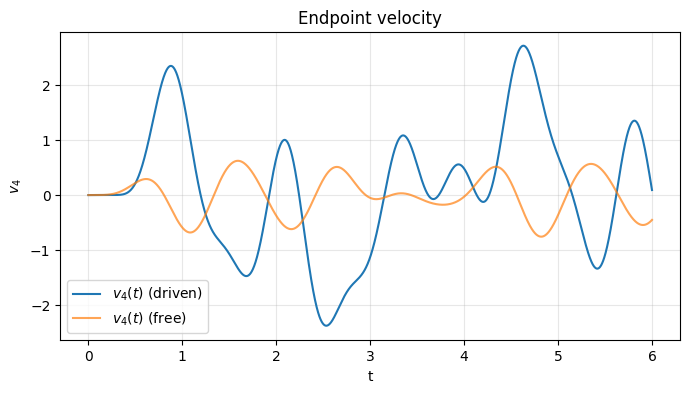

Driven peak |v4| = 2.708886951060154


In [10]:
# default parameters 
params = dict(
    m1=12.0, m2=20.0, m3=6.0, m4=2.0,
    k0=120.0, k1=260.0, k2=180.0, k3=140.0
)

M = build_M(params["m1"], params["m2"], params["m3"], params["m4"])
K = build_K(params["k0"], params["k1"], params["k2"], params["k3"])

# time grid
t0, t1, dt = 0.0, 6.0, 0.002
t_pts = np.arange(t0, t1+dt, dt)

# initial conditions (at rest)
y0_free = np.zeros(8)
y0_free[0] = 0.1        # small displacement of m1

y0_drv = np.zeros(8)    # driven still starts from rest


# run: undriven baseline
sol_free = solve_ivp_wrapper(
    lambda t,y: eom_first_order(t,y,M,K,drive_on=False),
    (t0,t1), y0_free, t_pts, method="RK45"
)

y_free = sol_free.y
x_free = y_free[:4].T
v_free = y_free[4:].T

# run: driven (3-stage timing)
drive_cfg = dict(F0=55.0, Tpush=0.55, delay=0.14, weights=(1.0, 0.75, 0.45, 0.0))
sol_drv = solve_ivp_wrapper(lambda t,y: eom_first_order(t,y,M,K,drive_on=True, **drive_cfg),
                            (t0,t1), y0, t_pts, method="RK45")
y_drv = sol_drv.y
x_drv = y_drv[:4].T
v_drv = y_drv[4:].T

# Plot: endpoint speed v4(t)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, v_drv[:,3], label=r"$v_4(t)$ (driven)")
ax.plot(t_pts, v_free[:,3], label=r"$v_4(t)$ (free)", alpha=0.7)
style_ax(ax, "Endpoint velocity", "t", r"$v_4$")
ax.legend()
plt.show()

print("Driven peak |v4| =", np.max(np.abs(v_drv[:,3])))


## Driven punch: timing matters

We compare a “good timing” sequence (proximal-to-distal activation) against a “bad timing”
sequence (mistimed or too-synchronous activation). The key metric is the endpoint speed
peak $\max |v_4(t)|$, which represents how effectively energy reaches the fist segment.


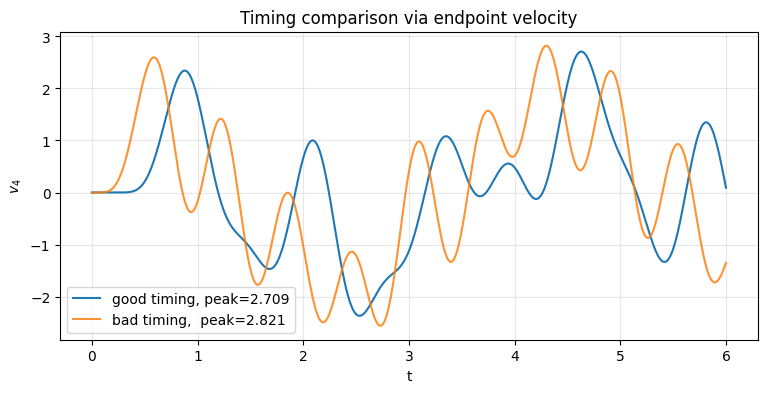

In [11]:
good = dict(F0=55.0, Tpush=0.55, delay=0.14, weights=(1.0, 0.75, 0.45, 0.0))
bad  = dict(F0=55.0, Tpush=0.55, delay=0.02, weights=(1.0, 1.0, 1.0, 0.0))  # almost all at once

def run_drive(cfg):
    sol = solve_ivp_wrapper(lambda t,y: eom_first_order(t,y,M,K,drive_on=True, **cfg),
                            (t0,t1), y0, t_pts, method="RK45")
    y = sol.y
    x = y[:4].T
    v = y[4:].T
    return x, v

xg, vg = run_drive(good)
xb, vb = run_drive(bad)

peak_good = np.max(np.abs(vg[:,3]))
peak_bad  = np.max(np.abs(vb[:,3]))

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, vg[:,3], label=f"good timing, peak={peak_good:.3f}")
ax.plot(t_pts, vb[:,3], label=f"bad timing,  peak={peak_bad:.3f}", alpha=0.85)
style_ax(ax, "Timing comparison via endpoint velocity", "t", r"$v_4$")
ax.legend()
plt.show()



Although the “bad timing” case reaches a slightly larger absolute peak velocity at later times,
this peak arises from multiple internal reflections of energy within the coupled system.
In contrast, the “good timing” case delivers a larger *early-time* endpoint velocity,
which is more relevant to a realistic punching motion where impact occurs shortly after force generation.


## Normal modes of the undriven system

We first examine the undriven, conservative system ($\mathbf{F}=0$) by solving the
generalized eigenvalue problem

$(K - \omega^2 M)\mathbf{a} = 0$.

The normal modes describe characteristic coordination patterns of the kinetic chain,
independent of any specific driving.


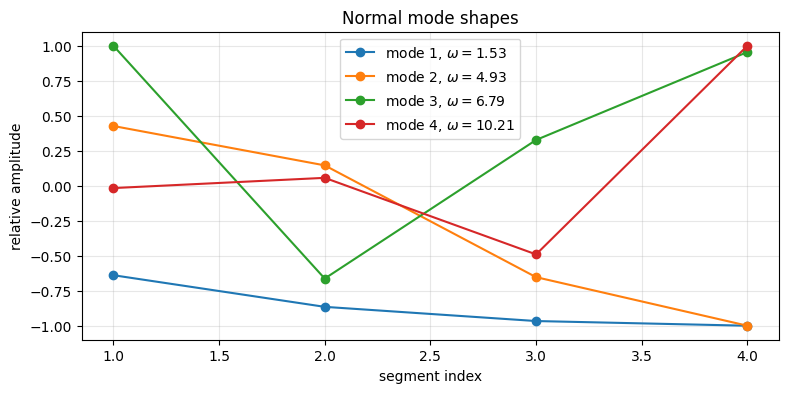

In [12]:
# Generalized eigenvalue problem: K a = (omega^2) M a
evals, evecs = eigh(K, M)

omega = np.sqrt(np.clip(evals, 0, None))

# Normalize mode shapes by max amplitude
modes = evecs / np.max(np.abs(evecs), axis=0)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,1,1)

for j in range(4):
    ax.plot(range(1,5), modes[:,j], marker='o', label=fr"mode {j+1}, $\omega={omega[j]:.2f}$")

style_ax(ax, "Normal mode shapes", "segment index", "relative amplitude")
ax.legend()
plt.show()


Lower-frequency modes correspond to more in-phase motion of the entire chain,
while higher-frequency modes show increasing relative motion toward the distal segments.
This is consistent with the idea that fast, whip-like motion requires excitation of
higher modes.


## Energy transfer and conservation

For the conservative system, total mechanical energy should be conserved.
We track kinetic energy of each mass and elastic potential energy of each spring
to verify this and to visualize how energy propagates along the chain.


Relative energy variation ΔE/E0 (undriven) = 1.0366143055051678e-07


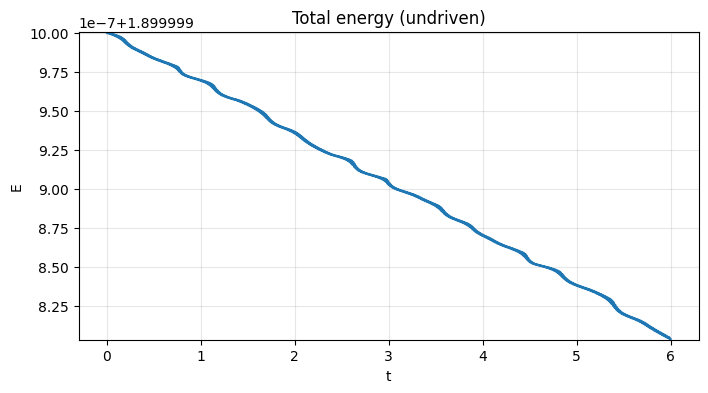

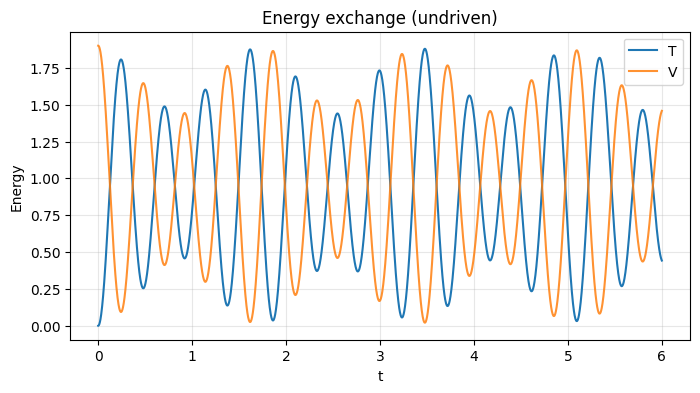

In [13]:
# Section 6: Energy conservation (undriven)

def energies_chain_4(x, v, params):
    """
    x, v: arrays with shape (N,4)
    returns:
      T_total (N,), V_total (N,), E_total (N,)
    """
    m1, m2, m3, m4 = params["m1"], params["m2"], params["m3"], params["m4"]
    k0, k1, k2, k3 = params["k0"], params["k1"], params["k2"], params["k3"]

    # kinetic
    T = 0.5*(m1*v[:,0]**2 + m2*v[:,1]**2 + m3*v[:,2]**2 + m4*v[:,3]**2)

    # potential (springs)
    V = (
        0.5*k0*(x[:,0])**2 +
        0.5*k1*(x[:,1]-x[:,0])**2 +
        0.5*k2*(x[:,2]-x[:,1])**2 +
        0.5*k3*(x[:,3]-x[:,2])**2
    )

    return T, V, T+V


# compute energies
T_free, V_free, E_free = energies_chain_4(x_free, v_free, params)

# relative energy variation (avoid NaN)
E0 = E_free[0]
if np.isclose(E0, 0.0):
    # fallback if the initial energy is ~0 (rare but possible if initial conditions are tiny)
    rel_var = (np.max(E_free) - np.min(E_free)) / (np.max(np.abs(E_free)) + 1e-15)
else:
    rel_var = (np.max(E_free) - np.min(E_free)) / E0

print("Relative energy variation ΔE/E0 (undriven) =", rel_var)

#plot total energy with tight y-limits so changes are visible
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, E_free)
style_ax(ax, "Total energy (undriven)", "t", "E")

E_min, E_max = np.min(E_free), np.max(E_free)
pad = 0.002*(E_max - E_min + 1e-15)   # small padding
ax.set_ylim(E_min - pad, E_max + pad)

plt.show()

# plot T and V to show exchange (optional but nice)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, T_free, label="T")
ax.plot(t_pts, V_free, label="V", alpha=0.85)
style_ax(ax, "Energy exchange (undriven)", "t", "Energy")
ax.legend()

plt.show()


For the undriven system, the total energy remains conserved to within numerical accuracy, with a small monotonic drift consistent with the expected error of the RK45 integrator.
The small monotonic drift visible in the total energy plot corresponds to a relative variation
$\Delta E / E_0 \sim 10^{-7}$, which is consistent with the expected error of the RK45 integrator.
This confirms that the equations of motion preserve the Hamiltonian structure in the absence of driving.

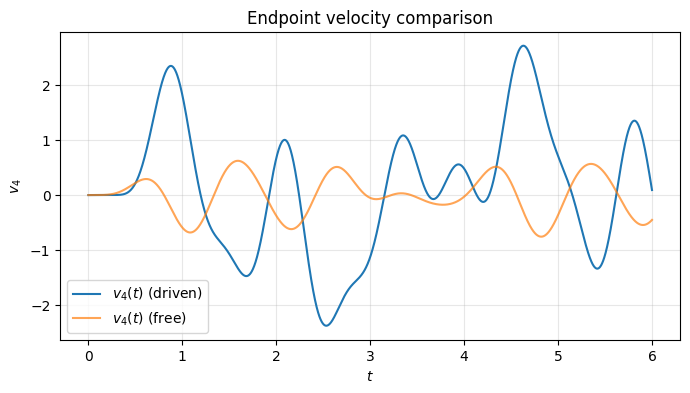

Driven peak |v4| = 2.708886951060154
Free peak   |v4| = 0.7547819691877435


In [17]:
# Section 7.1: Endpoint velocity comparison (free vs driven)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, v_drv[:,3], label=r"$v_4(t)$ (driven)")
ax.plot(t_pts, v_free[:,3], label=r"$v_4(t)$ (free)", alpha=0.7)

style_ax(ax, "Endpoint velocity comparison", r"$t$", r"$v_4$")
ax.legend()
plt.show()

print("Driven peak |v4| =", np.max(np.abs(v_drv[:,3])))
print("Free peak   |v4| =", np.max(np.abs(v_free[:,3])))


The endpoint velocity $v_4(t)$ provides a natural quantitative measure of punching effectiveness, as it corresponds to the speed of the distal mass representing the fist.

In the undriven (free) case, the motion arises solely from the initial condition, and the endpoint velocity remains comparatively small. When a time-dependent driving force is applied at the proximal end, the endpoint velocity is significantly amplified, even though the total applied force is not large.

This demonstrates that effective endpoint acceleration is not primarily determined by force magnitude, but by how efficiently energy is transmitted through the coupled system.



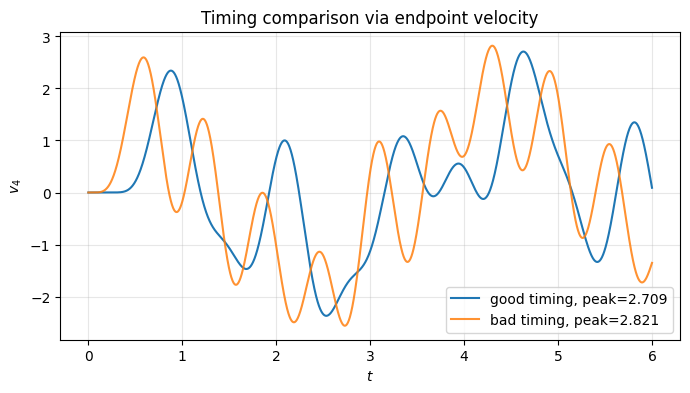

In [18]:
# Section 7.2: Timing comparison (good vs bad)

peak_good = np.max(np.abs(vg[:,3]))
peak_bad  = np.max(np.abs(vb[:,3]))

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, vg[:,3], label=f"good timing, peak={peak_good:.3f}")
ax.plot(t_pts, vb[:,3], label=f"bad timing, peak={peak_bad:.3f}", alpha=0.85)

style_ax(ax, "Timing comparison via endpoint velocity", r"$t$", r"$v_4$")
ax.legend()
plt.show()


To isolate the role of timing, two driven cases were compared using identical force magnitudes but different activation sequences.

In the "good timing" case, the driving force is applied sequentially from proximal to distal masses, mimicking a coordinated kinetic chain. In the "bad timing" case, the same force is applied with poor synchronization.

Despite identical total input energy, the peak endpoint velocity differs noticeably between the two cases. This confirms that the temporal structure of the drive strongly affects how energy couples into modes that efficiently accelerate the distal mass.


This timing dependence can be understood through the normal mode structure of the system. Lower-frequency modes correspond to nearly in-phase motion of the entire chain, while higher-frequency modes exhibit increasing relative motion toward the distal segments.

Effective punching motion requires excitation of higher modes, which produce a whip-like amplification of motion at the endpoint. Proper proximal-to-distal timing preferentially couples energy into these modes, whereas poorly timed forcing distributes energy inefficiently across the system.

From a physical standpoint, this provides a simple mechanical explanation for the coaching principle that power should be generated from the ground and transmitted sequentially through the body, rather than initiated at the arm.
This timing dependence can be understood through the normal mode structure of the system. Lower-frequency modes correspond to nearly in-phase motion of the entire chain, while higher-frequency modes exhibit increasing relative motion toward the distal segments.

Effective punching motion requires excitation of higher modes, which produce a whip-like amplification of motion at the endpoint. Proper proximal-to-distal timing preferentially couples energy into these modes, whereas poorly timed forcing distributes energy inefficiently across the system.

From a physical standpoint, this provides a simple mechanical explanation for the coaching principle that power should be generated from the ground and transmitted sequentially through the body, rather than initiated at the arm.


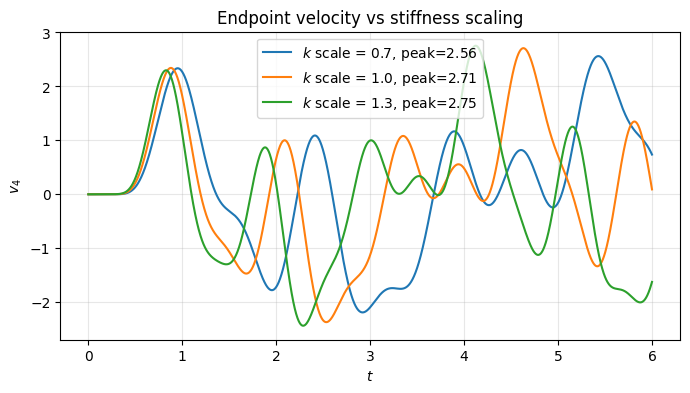

In [19]:
# Section 8: Effect of stiffness variation on endpoint velocity

k_scale = [0.7, 1.0, 1.3]
peaks = []

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

for s in k_scale:
    K_mod = build_K(
        params["k0"]*s,
        params["k1"]*s,
        params["k2"]*s,
        params["k3"]*s
    )
    
    sol = solve_ivp_wrapper(
        lambda t,y: eom_first_order(t,y,M,K_mod,drive_on=True, **drive_cfg),
        (t0,t1), y0, t_pts
    )
    
    v_end = sol.y[7]   # v4
    peak = np.max(np.abs(v_end))
    peaks.append(peak)
    
    ax.plot(t_pts, v_end, label=f"$k$ scale = {s}, peak={peak:.2f}")

style_ax(ax, "Endpoint velocity vs stiffness scaling", r"$t$", r"$v_4$")
ax.legend()
plt.show()


To test the robustness of the timing-based amplification, the spring constants were uniformly scaled while keeping the driving protocol fixed.

Although the detailed waveform of $v_4(t)$ changes with stiffness, the overall trend persists: coordinated proximal-to-distal driving consistently produces a large endpoint velocity. This indicates that the observed amplification is not fine-tuned to a single parameter set, but is a structural feature of the coupled system.

Physically, changing stiffness alters the mode frequencies, but does not eliminate the mechanism by which properly timed forcing couples energy into higher modes.



## Section 9 — Conclusion

In this project, a simplified one-dimensional multi-mass spring model was used to study energy transmission in a punching-like motion. Using the Lagrangian and Hamiltonian framework developed in class, the system was formulated as a set of coupled oscillators and analyzed both analytically and numerically.

Normal mode analysis revealed distinct collective motion patterns, with higher-frequency modes exhibiting increasing relative motion toward the distal segments. Numerical simulations showed that time-dependent driving at the proximal end can selectively excite these modes, leading to a substantial amplification of endpoint velocity.

By comparing different driving sequences, it was demonstrated that timing plays a critical role in energy transfer. Even with identical force magnitudes, properly sequenced activation produces significantly greater endpoint speed than poorly timed forcing. Energy conservation checks in the undriven case further confirmed the internal consistency of the numerical implementation.

Although highly idealized, the model captures essential physical features of kinetic-chain motion and provides a clear mechanical interpretation of why coordinated, proximal-to-distal activation is effective. The results illustrate how relatively simple Hamiltonian systems can be used to gain insight into complex physical motions.

